Imports:

In [1]:
import numpy as np
import random
import pandas as pd
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import shutil
from glob import glob
import matplotlib.pyplot as plt

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

Data Collection:

In [2]:
path = '/Covid_CT_Detection/'
positive_sub = 'CT_COVID/'
negative_sub = 'CT_NonCOVID/'

In [3]:
def image_getter():
    # jpg and png files
    positive_images_list = glob(os.path.join(positive_sub,"*.png"))

    negative_images_list = glob(os.path.join(negative_sub,"*.png"))
    negative_images_list.extend(glob(os.path.join(negative_sub,"*.jpg")))

    cov_positive = {'class': 'CT_COVID',
            'path': positive_sub,
            'images': positive_images_list}

    cov_negative = {'class': 'CT_NonCOVID',
                'path': negative_sub,
                'images': negative_images_list}

    return cov_positive, cov_negative, positive_images_list, negative_images_list

In [4]:
cov_positive, cov_negative, positive_images_list, negative_images_list = image_getter()

total_positive_covid = len(positive_images_list)
total_negative_covid = len(negative_images_list)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


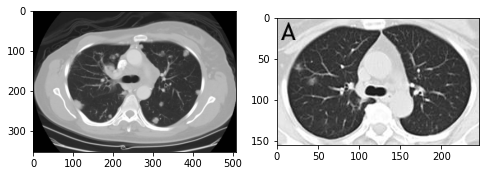

In [5]:
image_positive = cv2.imread(os.path.join(positive_images_list[51]))
image_negative = cv2.imread(os.path.join(negative_images_list[22]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [6]:
print("Image POS Shape {}".format(image_positive.shape))
print("Image NEG Shape {}".format(image_negative.shape))

Image POS Shape (155, 247, 3)
Image NEG Shape (353, 508, 3)


Data Formatting:

In [7]:
# Create Train-Test Directory
subdirs  = ['train/', 'validation/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [8]:
# Create test set
random.seed(12)
test_ratio = 0.1

total_positive_images = 0
total_negative_images = 0

for cases in [cov_positive, cov_negative]:
    total_cases = len(cases['images']) #number of total images
    if cases == cov_positive:
        total_positive_images += total_cases
    elif cases == cov_negative:
        total_negative_images += total_cases
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.move(files, 'validation/' + cases['class'])

CT_COVID 34
CT_NonCOVID 39


In [9]:
cov_positive, cov_negative, positive_images_list, negative_images_list = image_getter()

# Create test set
random.seed(10)
test_ratio = 0.1

for cases in [cov_positive, cov_negative]:
    if cases == cov_positive:
        total_cases = total_positive_images
    elif cases == cov_negative:
        total_cases = total_negative_images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.move(files, 'test/' + cases['class'])

CT_COVID 34
CT_NonCOVID 39


In [10]:
cov_positive, cov_negative, positive_images_list, negative_images_list = image_getter()

total_positive_covid = len(positive_images_list)
total_negative_covid = len(negative_images_list)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 281
Total Negative Cases Covid19 images: 319


In [12]:
# Create training set
for cases in [cov_positive, cov_negative]:
    shutil.move(cases['class'], 'train/')

In [13]:
total_train_covid = len(os.listdir('train/CT_COVID'))
total_train_noncovid = len(os.listdir('train/CT_NonCOVID'))
total_test_covid = len(os.listdir('test/CT_COVID'))
total_test_noncovid = len(os.listdir('test/CT_NonCOVID'))
total_validation_covid = len(os.listdir('validation/CT_NonCOVID'))
total_validation_noncovid = len(os.listdir('validation/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))
print("Validation sets images COVID: {}".format(total_validation_covid))
print("Validation sets images Non COVID: {}".format(total_validation_noncovid))

Train sets images COVID: 281
Train sets images Non COVID: 319
Test sets images COVID: 34
Test sets images Non COVID: 39
Validation sets images COVID: 39
Validation sets images Non COVID: 39


Model:

In [14]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras as ks

In [15]:
batch_size = 32
epochs = 50
img_height = 224
img_width = 224

In [16]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                          horizontal_flip = True)
val_image_generator = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip = True)
test_image_generator = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip = True)

In [19]:
image_size = [224, 224]
base_model = tf.keras.applications.MobileNetV2(input_shape=image_size + [3],
include_top=False,
weights='imagenet')
base_model.trainable = False

In [18]:
image_size = [224, 224]

base_model = tf.keras.applications.vgg16.VGG16(input_shape=image_size + [3],
include_top=True, weights='imagenet')

base_model.trainable = False

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).  Received: input_shape=[224, 224, 3]

In [20]:
train_dir = os.path.join('train')
test_dir = os.path.join('test')
val_dir = os.path.join('validation')


total_train = total_train_covid + total_train_noncovid
total_val = total_validation_covid + total_validation_noncovid
total_test = total_test_covid + total_test_noncovid

print(total_train, total_val, total_test)

600 78 73


In [21]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='categorical')
val_data_gen = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='categorical')
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='categorical')

Found 600 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [22]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [26]:
history = model.fit(
  train_data_gen,
  validation_data=test_data_gen,
  epochs=26,
  steps_per_epoch=len(train_data_gen),
  validation_steps=len(test_data_gen))

Epoch 1/26
19/19 [==============================] - 3s 144ms/step - loss: 0.1235 - accuracy: 0.9483 - val_loss: 0.7501 - val_accuracy: 0.8082
Epoch 2/26
19/19 [==============================] - 3s 139ms/step - loss: 0.1474 - accuracy: 0.9467 - val_loss: 0.6009 - val_accuracy: 0.8630
Epoch 3/26
19/19 [==============================] - 3s 139ms/step - loss: 0.1084 - accuracy: 0.9500 - val_loss: 0.8718 - val_accuracy: 0.8082
Epoch 4/26
19/19 [==============================] - 3s 136ms/step - loss: 0.0969 - accuracy: 0.9483 - val_loss: 0.6040 - val_accuracy: 0.8219
Epoch 5/26
19/19 [==============================] - 3s 135ms/step - loss: 0.0999 - accuracy: 0.9600 - val_loss: 0.7915 - val_accuracy: 0.8219
Epoch 6/26
19/19 [==============================] - 3s 141ms/step - loss: 0.1096 - accuracy: 0.9433 - val_loss: 0.8021 - val_accuracy: 0.7945
Epoch 7/26
19/19 [==============================] - 3s 140ms/step - loss: 0.0962 - accuracy: 0.9550 - val_loss: 0.5882 - val_accuracy: 0.8356
Epoch 

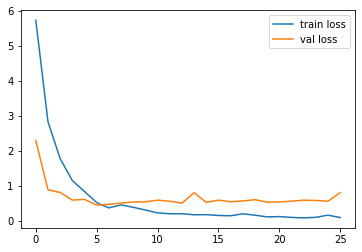

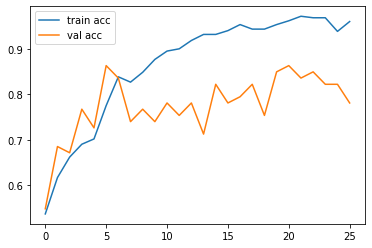

In [25]:
# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

# Plot accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

In [27]:
test_loss, test_acc = model.evaluate(val_data_gen)
print('Test accuracy:', test_acc)

3/3 [==============================] - 0s 64ms/step - loss: 0.6794 - accuracy: 0.8493
Test accuracy: 0.8493150472640991
